In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

In [167]:
class particle_system:
    def __init__(self,grid):#grid:integer tuple
        self.grid=grid
        self.particles=[]
        
    def insert_particles(self,n,update_pos,update_intensity,start_pos=None,intensity=None):
        if start_pos is None:
            x_data = np.random.uniform(low=0, high=self.grid[0], size=n)
            y_data= np.random.uniform(low=0, high=self.grid[1], size=n)
            start_pos=[(int(x_data[i]),int(y_data[i]))for i,x in enumerate(x_data)]
            
        if intensity is None:
            intensity=[1 for i in range(n)]
            
        for i in range(n):
            self.particles.append(particle(self.grid,start_pos[i],update_pos,intensity[i],update_intensity))
    def evolve(self,dt):
        for p in self.particles:
            p.evolve(dt)
    def positions(self):
        return [p.pos for p in self.particles]
    def intensities(self):
        return [p.intensity for p in self.particles]

In [168]:
class particle:
    def __init__(self,grid,start_pos,update_pos,intensity,update_intensity):
        self.grid=grid#dimensions of the space it's restricted to
        
        self.pos=start_pos#current position
        self.__class__.update_pos=update_pos
        
        self.intensity=intensity#current intensity
        self.__class__.update_intensity = update_intensity
        
    def evolve(self,dt):
        self.pos=self.update_pos(dt)
        self.intensity=self.update_intensity(dt)
        
        

In [169]:
def inside_grid(pos,grid):#assume grid has left bottom corner in (0,0), check if a given point is inisde of it
    return pos[0]>=0 and pos[0]<=grid[0] and pos[1]>=0 and pos[1]<=grid[1]

In [186]:
def brownian_update(part,dt,D,drift=[0,0]):
    mean=[dt*d for d in drift]
    cov=np.identity(2)*dt*D*2#the 2 term appears because I think that's the 'true' variance formula in Brownian motion but D may as well just be any number, not the diffusion coeff
    dx, dy = np.random.multivariate_normal(mean, cov, 1).T
    dx=int(dx[0])
    dy=int(dy[0])#unpack the unnecessary array and make integers since we are on an integer grid
    if (dx>part.grid[0] or dy>part.grid[1]):
        print("The time step in brownian motion seems to be too large relative to grid size")#just to see if I'm doing anything stupid
    pos=part.pos
    new_pos=tuple(map(sum, zip(pos, (dx,dy))))
    if inside_grid(new_pos,part.grid):
        return new_pos
    else:#need to figure out where and when it intersects the boundary. For now let's just resample
        return brownian_update(part,dt,D,drift)
        
        
    

It's time to use this simulation to do tracking

In [303]:
sys=particle_system((100,100))
n=5
sys.insert_particles(n,lambda x,y : brownian_update(x,y,1,[0,0]),lambda x,y : 1)

dt=50
beg_pos=sys.positions()
beg_int=sys.intensities()

sys.evolve(dt)

end_pos=sys.positions()
end_int=sys.intensities()


We need to transform it into a transportation problem

In [292]:
a=np.array(beg_int).reshape((n,1))
b=np.array(end_int).reshape((n,1))#try to make the shapes match with all of the linear algebra behind this


In [293]:
def L2_cost(source,sink):
    C=np.empty((len(source),len(sink)))
    for i,pos1 in enumerate(source):
        for j, pos2 in enumerate(sink):
            C[i,j]=np.sqrt((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)
    return C

In [304]:
C = L2_cost(beg_pos,end_pos)

In [295]:
import cvxpy as cp

In [305]:
P=cp.Variable((n,n))

In [306]:
u = np.ones((n,1))
v = np.ones((n,1))
U = [0 <= P, cp.matmul(P,u)==a, cp.matmul(P.T,v)==b]

In [307]:
objective = cp.Minimize( cp.sum(cp.multiply(P,C)) )
prob = cp.Problem(objective, U)
result = prob.solve()

In [308]:
P.value

array([[1.00000000e+00, 1.00956553e-10, 1.29634632e-10, 1.14254242e-10,
        1.07232951e-10],
       [1.11989735e-10, 9.99999999e-01, 1.84672855e-10, 1.60721923e-10,
        1.08173386e-10],
       [1.41689887e-10, 2.67398378e-10, 9.99999998e-01, 1.74458978e-09,
        1.93276561e-10],
       [8.39312426e-11, 8.95449067e-11, 1.88087442e-09, 9.99999998e-01,
        9.94840298e-11],
       [1.14760976e-10, 1.07410045e-10, 1.51642962e-10, 1.34252437e-10,
        9.99999999e-01]])

Visualise this

In [309]:
beg_x,beg_y= zip(*beg_pos)
end_x,end_y= zip(*end_pos)

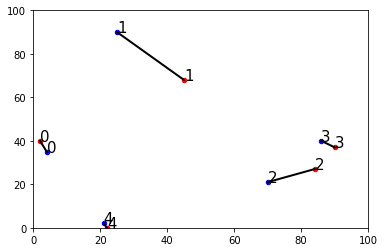

In [310]:
fig,ax=plt.subplots()

ax.set_xlim([0,sys.grid[0]])
ax.set_ylim([0,sys.grid[1]])
ax.scatter(beg_x,beg_y,color='blue',s=20)
ax.scatter(end_x,end_y,color='red',s=20)
for i,pos in enumerate(beg_pos):
    ax.annotate(i,(pos[0],pos[1]),size=15)
for i,pos in enumerate(end_pos):
    ax.annotate(i,(pos[0],pos[1]),size=15)
    
    
for i in range(n):
    for j in range(n):
        if P.value[i,j]>0.1:#so there is a non-neglegible transport between the two
            xvals=[beg_x[i],end_x[j]]
            yvals=[beg_y[i],end_y[j]]
            thickness=1.8*(P.value[i,j]/a[i])+0.2 #scaled by what fraction of the total transport from i it is
            ax.plot(xvals,yvals,linewidth=thickness,color='black')